In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(10,10)

In [2]:
mean_shape=np.load('/home/zhangxk/AIProject/DeepAlignmentNetwork/data/meanFaceShape.npz')['meanShape']
mean_shape=mean_shape-np.min(mean_shape,0)
print(np.max(mean_shape,0))

[150.02061 144.52034]


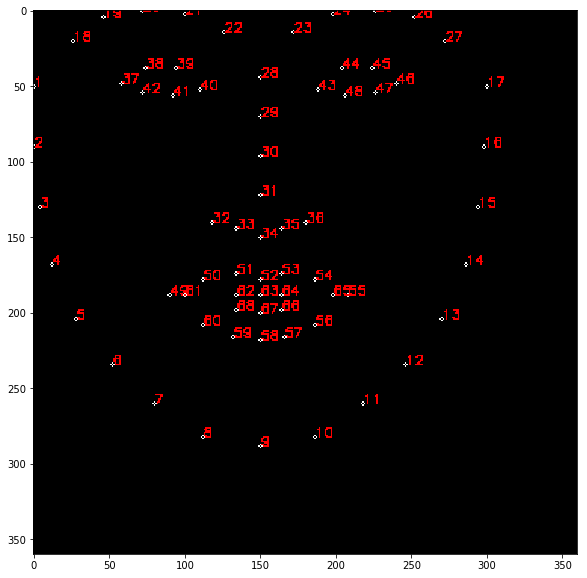

In [3]:
I=np.zeros((360,360,3),dtype=np.uint8)
for i,shape in enumerate(mean_shape):
    x,y=int(shape[0])*2,int(shape[1])*2
    I=cv2.circle(I,(x,y),1,(255,255,255),1)
    I=cv2.putText(I,str(i+1),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),lineType=1)
plt.imshow(I)

In [4]:
def loadImage(imagepath,labelpath):
    I=cv2.imread(imagepath)
    label=np.genfromtxt(labelpath,dtype=np.float32,delimiter=' ',skip_header=3,skip_footer=1)
    return I,label

(366, 650, 3)


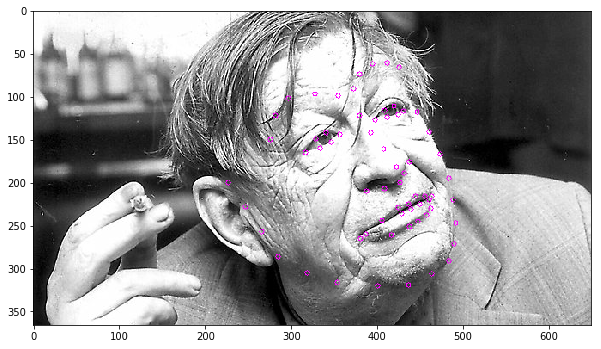

In [6]:
imagepath='data/indoor_168.png'
labelpath='data/indoor_168.pts'
X,Y=loadImage(imagepath,labelpath)

def showImage(X,Y):
    X=np.copy(X)
    print(X.shape)
    for i,shape in enumerate(Y):
        x,y=int(shape[0]),int(shape[1])
        X=cv2.circle(X,(x,y),3,(255,0,255),1)
#         X=cv2.putText(X,str(i+1),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),lineType=1)
    plt.imshow(X)
showImage(X,Y)

### when trainsform $\vec{a}$ to $\vec{b}$,using follow forward formula,first rotation,then scale 

$$M=\begin{bmatrix}
       cos(\theta) & -sin(\theta) \\sin(\theta) &cos(\theta)
     \end{bmatrix}.\frac{\|b\|_2}{\|a\|_2}$$
$$cos(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{a^{T}b}{\|a\|_2\|b\|_2}.\frac{\|b\|_2}{\|a\|_2}=\frac{a^{T}b}{\|a\|_{2}^{2}}$$
$$sin(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{a \times b}{\|a\|_2\|b\|_2}.\frac{\|b\|_2}{\|a\|_2}=\frac{a \times b}{\|a\|_{2}^{2}}$$
>so for 2D vector,formula:
$$cos(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{x_{a}x_{b}+y_{a}y_{b}}{x_{a}^{2}+y_{a}^{2}}$$
$$sin(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{x_{a}y_{b}-y_{a}y_{a}}{x_{b}^{2}+y_{a}^{2}}$$
>if you have N's pairs $\vec{a}^{(i)},\vec{b}^{(i)}$,analog above , approximation look like this::
$$cos(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{\sum x_{a}^{(i)}x_{b}^{(i)}+y_{a}^{(i)}y_{b}^{(i)}}{\sum {x_{a}^{(i)}}^2+{y_{a}^{(i)}}^{2}}$$
$$sin(\theta)\frac{\|b\|_2}{\|a\|_2}=\frac{\sum x_{a}^{(i)}y_{b}^{(i)}-x_{b}^{(i)}y_{a}^{(i)}}{\sum {x_{b}^{(i)}}^{2}+{y_{a}^{(i)}}^{2}}$$
>forward transform:$I'(T(x),T(y))=I(x,y)$

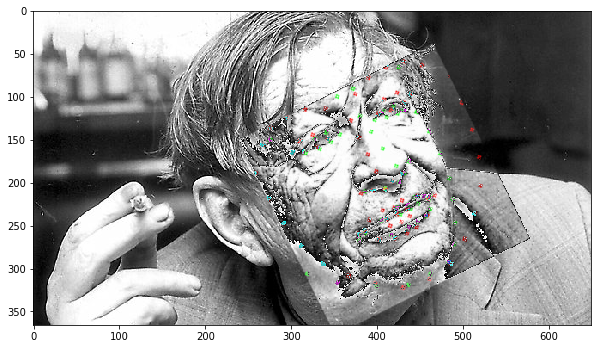

In [8]:
def affineParam(src,dst):
    src_mean=np.mean(src,axis=0)
    dst_mean=np.mean(dst,axis=0)
    
    src_central=src-src_mean
    dst_central=dst-dst_mean
    
    dot_result=np.sum(src_central*dst_central)
    cross_result=np.sum(src_central[:,0]*dst_central[:,1]-src_central[:,1]*dst_central[:,0])
    src_norm_square=np.sum(src_central**2)
    
    a=dot_result/src_norm_square
    b=cross_result/src_norm_square
    
    M=np.array([[a,-b],[b,a]])
    
    T=-M.dot(src_mean)+dst_mean
    
    return M,T
def drawStandLandmark(I,baseshape,color=(255,0,0)):
    I=np.copy(I)
    for i,shape in enumerate(baseshape):
        x,y=int(shape[0]),int(shape[1])
        I=cv2.circle(I,(x,y),1,color,1)
    return I

mean_shape=np.load('/home/zhangxk/AIProject/DeepAlignmentNetwork/data/meanFaceShape.npz')['meanShape']
mean_shape=mean_shape-np.min(mean_shape,0)
imagepath='data/indoor_168.png'
labelpath='data/indoor_168.pts'
X,Y=loadImage(imagepath,labelpath)
H,W,_=X.shape

R,T=affineParam(Y,mean_shape)
M=np.zeros((2,3))
M[:,:2]=R
M[:,2]=T
X1=cv2.warpAffine(X,M,(150,150))
X1=drawStandLandmark(X1,mean_shape)
X1=drawStandLandmark(X1,Y.dot(R.T)+T,color=(0,255,0))
plt.imshow(X1)

RI=np.linalg.inv(R)
TI=-RI.dot(T)
M[:,:2]=RI
M[:,2]=TI
X2=cv2.warpAffine(X1,M,(W,H))
plt.imshow(X2+X)

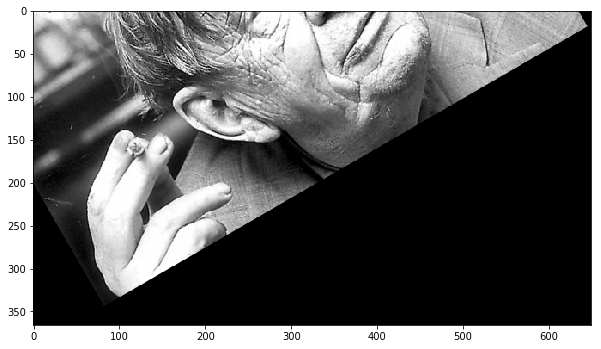

In [10]:
def rotateAround(center,angle=60):
    center=np.array(center)
    radius=angle/180*np.pi
    c=np.cos(radius)
    s=np.sin(radius)
    M=np.array([[c,s],[-s,c]])
    T=-M.dot(center)+center
    
    return M,T
imagepath='data/indoor_168.png'
labelpath='data/indoor_168.pts'
X,Y=loadImage(imagepath,labelpath)
H,W,_=X.shape
CX,CY=W//2,H//2
CX,CY=0,200
R,T=rotateAround([CX,CY],angle=30)
M=np.zeros((2,3))
M[:,:2]=R
M[:,2]=T
X1=cv2.warpAffine(X,M,(W,H))
plt.imshow(X1)

In [11]:
#tensorflow method
import tensorflow as tf
import tensorflow.contrib as tfcontrib
tf.enable_eager_execution()

tf.Tensor(
[[ 0.8660254  -0.5         0.          0.5         0.86602545  0.
   0.          0.        ]], shape=(1, 8), dtype=float32)
tf.Tensor(
[[ 140.19238]
 [-123.20509]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[   0.8660254    -0.5         140.19238       0.5           0.86602545
  -123.20509       0.            0.        ]], shape=(1, 8), dtype=float32)


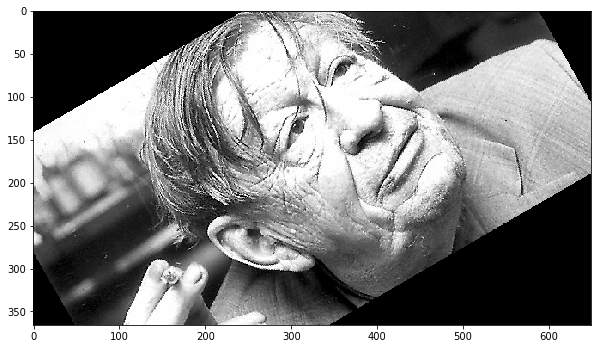

In [12]:
imagepath='data/indoor_168.png'
labelpath='data/indoor_168.pts'
X,Y=loadImage(imagepath,labelpath)
H,W,_=X.shape
CX,CY=W//2,H//2
CX,CY=300,200
X=tf.constant(X,tf.uint8)
R,T=rotateAround([CX,CY],angle=30)

R=tf.constant(R,tf.float32)
R=tf.matrix_inverse(R)
RI=R
R=tf.pad(R,[[0,0],[0,1]])
R=tf.reshape(R,(-1,6))
R=tf.pad(R,[[0,0],[0,2]])
print(R)
T=tf.constant(T,tf.float32)
TI=tf.expand_dims(-T,1)
T=tfcontrib.image.translations_to_projective_transforms(T)
# print(T)
offset=tf.matmul(RI,TI)
print(offset)
M=tfcontrib.image.compose_transforms(R,T)
print(M)
Xout=tfcontrib.image.transform(X,M[0],output_shape=(X.shape[0],X.shape[1]))
Xout=Xout.numpy()
plt.imshow(Xout)